# Accessing higher energy states with Qiskit Pulse

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import execute
import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform

#import helper_lab6 as helper
from qiskit.test.mock import FakeArmonk
from qiskit.providers.aer import PulseSimulator

from qiskit.tools.monitor import job_monitor

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
#backend = FakeArmonk()

# sample duration for pulse instructions 
#dt = 1e-9# create the model
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt
#duffing_model = helper.get_transmon(dt)# get qubit frequency from Duffing model
#qubit_lo_freq = duffing_model.hamiltonian.get_qubit_lo_from_drift()

assert backend_config.open_pulse, "Backend doesn't support Pulse"

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
f01 = default_qubit_freq
f12 = default_qubit_freq-0.34719*GHz
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")
print(f"Qubit {qubit} has an anharm frequency of {f12/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 8192

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

ibmqfactory._initialize_providers:WARNING:2021-05-31 09:23:50,680: Unable to instantiate provider for {'hub': 'iqc2021-1', 'group': 'challenge-167', 'project': 'ex4'}: Traceback (most recent call last):
  File "/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/providers/ibmq/api/session.py", line 278, in request
    response.raise_for_status()
  File "/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/requests/models.py", line 943, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://api-qcon.quantum-computing.ibm.com/api/Network/iqc2021-1/Groups/challenge-167/Projects/ex4/devices/v/1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/doki/miniconda3/envs/myqis/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py", line 474, in _initialize_providers
    provider = AccountProvider(provid

Qubit 0 has an estimated frequency of 4.971862581660047 GHz.
Qubit 0 has an anharm frequency of 4.624672581660047 GHz.


We define some additional helper functions.

In [37]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result() # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

In [4]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [5]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [6]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

## 1. Discriminating the $|0\rangle$ and $|1\rangle$ states <a id="discrim01"></a>

### 1A. 0->1 Frequency Sweep  <a id="freqsweep01"></a>

In [11]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [8]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.3)

The frequency sweep will go from 4.9518604617746345 GHz to 4.9918604617746345 GHz using 75 frequencies. The drive power is 0.3.


In [9]:
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [9]:
#from qiskit.tools.monitor import job_monitor
#print(ground_freq_sweep_job.job_id())
#job_monitor(ground_freq_sweep_job)
ground_freq_sweep_job = backend.retrieve_job('60afc0da4a088cf5c8c51fea')

In [10]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(ground_freq_sweep_job, average=True)

We fit our data to a Lorentzian curve and extract the calibrated frequency.

In [7]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [12]:
# do fit in Hz
(ground_sweep_fit_params, 
 ground_sweep_y_fit) = fit_function(ground_sweep_freqs,
                                   ground_freq_sweep_data, 
                                   lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [7, 4.975*GHz, 1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

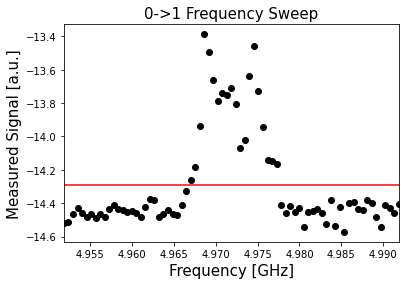

In [13]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_sweep_freqs/GHz, ground_sweep_y_fit, color='red')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [14]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.9718605 GHz to 2.2509315 GHz.


### 1B. 0->1 Rabi Experiment <a id="rabi01"></a>

In [16]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

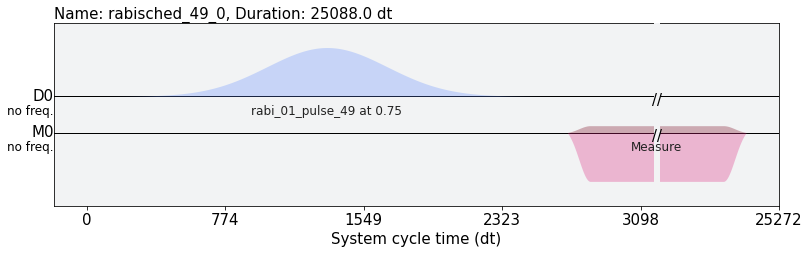

In [17]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name=f'rabi_01_pulse_%d at {drive_amp}' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='rabisched_%d_0' % ii)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)
    
# Draw rabi schedule
rabi_01_schedules[-1].exclude(channels=acq_chan).draw()

In [18]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [16]:
rabi_01_job = backend.run(rabi_01_expt_program)

In [ ]:
print(rabi_01_job.job_id())
job_monitor(rabi_01_job)

In [19]:
rabi_01_job = backend.retrieve_job('60afd0d6e42d8481a377a51f')

In [20]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True)

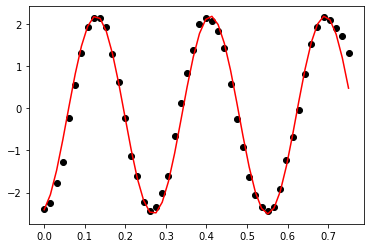

In [23]:
#THIS CELL REQUIRE MANUALLY FITTING, WHICH WASTE TIME!!
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, 0, 0.25, 0.5])

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

'''plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)'''
plt.show()

In [47]:
print("Pi amplitude (0->1) is %.3f" % pi_amp_01)

Pi amplitude (0->1) is 0.128


Using these results, we define our $0\rightarrow1$ $\pi$ pulse.

In [12]:
pi_amp_01 = 0.126
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

### 1C. Build the 0,1 discriminator <a id="builddiscrim01"></a>

In [50]:
# Create the two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure << one_schedule.duration

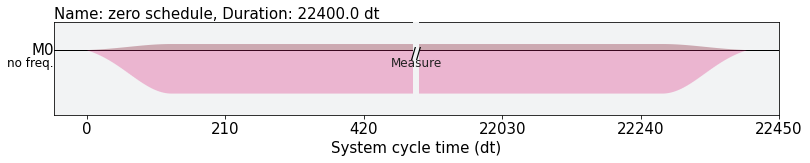

In [51]:
zero_schedule.draw()

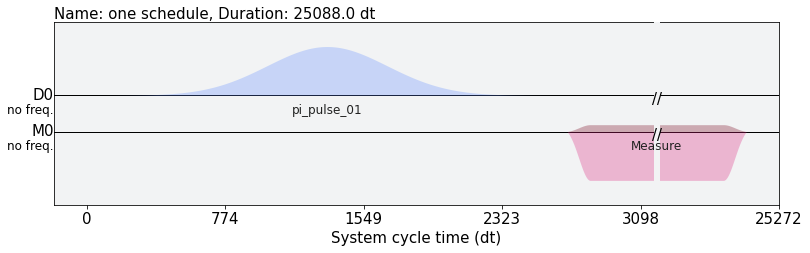

In [52]:
one_schedule.draw()

In [53]:
# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

In [54]:
IQ_01_job = backend.run(IQ_01_program)

In [ ]:
print(IQ_01_job.job_id())
job_monitor(IQ_01_job)

In [176]:
#IQ_01_job = backend.retrieve_job('60afd14c4e2427ff562caf32')
IQ_01_job = backend.retrieve_job('60b04e0d7ff605826befec1b')

In [177]:
# Get job data (single); split for zero and one
IQ_01_data = get_job_data(IQ_01_job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]
#zero_data = IQ_01_job.result().get_memory(0)
#one_data = IQ_01_job.result().get_memory(1)

Below, we display the IQ plot. The blue centroid denotes the $|0\rangle$ state, while the red centroid denotes the $|1\rangle$ state. (Note: If the plot looks off, rerun the notebook)

In [178]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    # Plot a large dot for the average result of the zero and one states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

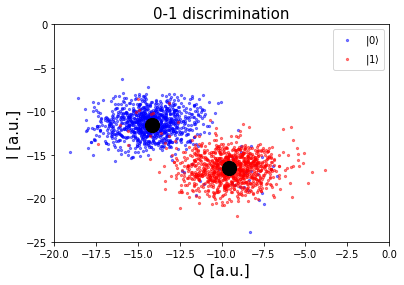

In [179]:
x_min = -20
x_max = 0
y_min = -25
y_max = 0
IQ_01_plot(x_min, x_max, y_min, y_max)

In [165]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [166]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  

IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
print(IQ_01_data.shape) # verify IQ data shape

(2048, 2)


In [167]:
# construct vector w/ 0's and 1's (for testing)
state_01 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_01 = np.concatenate((state_01, np.ones(NUM_SHOTS)))
print(len(state_01))

# Shuffle and split data into training and test sets
IQ_01_train, IQ_01_test, state_01_train, state_01_test = train_test_split(IQ_01_data, state_01, test_size=0.5)

2048


In [168]:
# Set up the LDA
LDA_01 = LinearDiscriminantAnalysis()
LDA_01.fit(IQ_01_train, state_01_train)

LinearDiscriminantAnalysis()

In [169]:
# test on some simple data 
print(LDA_01.predict([[0,0], [10, 0]]))

[0. 1.]


In [170]:
# Compute accuracy
score_01 = LDA_01.score(IQ_01_test, state_01_test)
print(score_01)

0.9638671875


The last step is to plot the separatrix. 

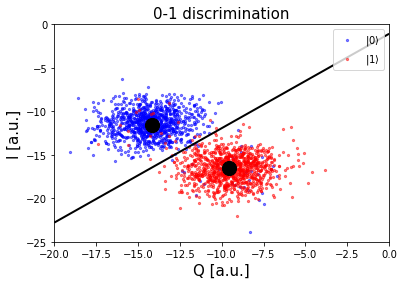

In [171]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

IQ_01_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_01, x_min, x_max, y_min, y_max, NUM_SHOTS)

## 2. Discriminating the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states <a id="discrim012"></a> 

### 2A. Computing the 1->2 frequency <a id="freq12"></a>

#### 1->2 Frequency Sweep using the sideband method <a id="sideband12"></a>

In [41]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (Waveform): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        Waveform: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse    

In [42]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.571862581660047 GHz to 5.001862581660046 GHz using 75 frequencies. The drive power is 0.3.


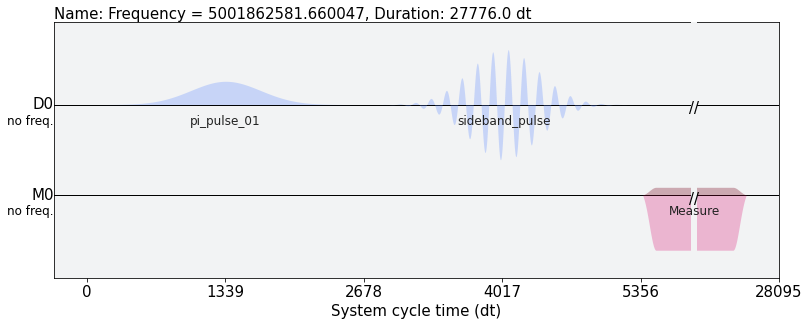

In [43]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = cal_qubit_freq + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [126]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

In [127]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)


60b053019f32f9a72a0b7fe2
Job Status: job has successfully run


In [83]:
#excited_freq_sweep_job = backend.retrieve_job('60afd1ae5255f033a138785b')
excited_freq_sweep_job = backend.retrieve_job('60b053019f32f9a72a0b7fe2')

In [128]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

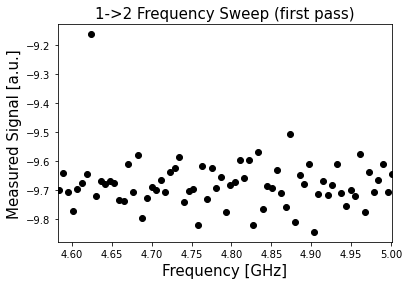

In [129]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [14]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [131]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 10)
approx_12_freq = maxima

Freq. dips:  []


In [16]:
cal_qubit_freq = default_qubit_freq
approx_12_freq = [default_qubit_freq-0.34719
*GHz]

The frequency sweep will go from 4.614672581660047 GHz to 4.6346725816600465 GHz using 75 frequencies. The drive power is 0.3.


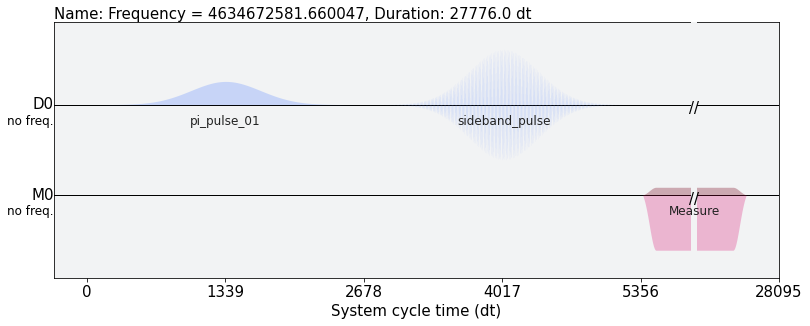

In [44]:
# smaller range refined sweep
num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-10*MHz, 10*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [26]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

In [27]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

60b326294e242735dd2cd7f1
Job Status: job is queued (28)    

KeyboardInterrupt: 

In [52]:
refined_excited_freq_sweep_job = backend.retrieve_job('60b3b2d57ff60570d7f0122a')

In [53]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

Let's plot and fit the refined signal, using the standard Lorentzian curve.

In [54]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

In [ ]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [47]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6235371 GHz.


In [63]:
qubit_12_freq = 4.6235*GHz
qubit_12_freq

4623250000.0

### 2B. 1->2 Rabi Experiment  <a id="rabi12"></a>

Now that we have a good estimate for the $1\rightarrow2$ frequency, we perform a Rabi experiment to obtain the $\pi$ pulse amplitude for the $1\rightarrow2$ transition. To do so, we apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency (using the sideband method).

In [64]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [65]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [66]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [67]:
rabi_12_job = backend.run(rabi_12_expt_program)

In [68]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

60b46b405318c6457381f638
Job Status: job has successfully run


In [69]:
rabi_12_job = backend.retrieve_job('60b46b405318c6457381f638')
#rabi_12_job = backend.retrieve_job('60b368944e24278b8d2cda47')

In [70]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

We plot and fit our data as before.

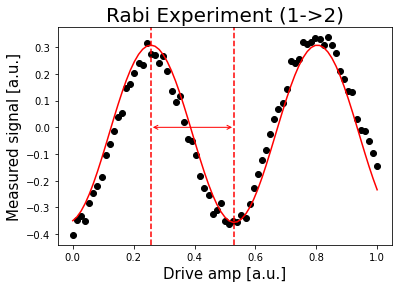

In [71]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [4, 0, 0.4, 0.5])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
#plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [72]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.62325 GHz.
Pi Amplitude (1->2) = 0.2562815702572885


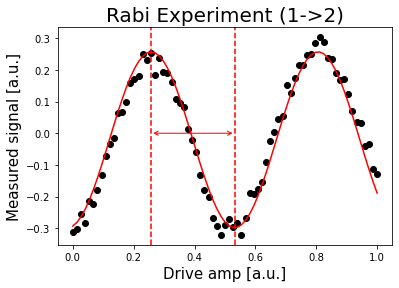

In [19]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [4, 0, 0.4, 0.5])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
#plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [22]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6235371 GHz.
Pi Amplitude (1->2) = 0.25743692436405224


In [18]:
pi_amp_12 = 0.25743692436405224

With this information, we can define our $1\rightarrow2$ $\pi$ pulse (making sure to add a sideband at the $1\rightarrow2$ frequency).

In [19]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

### 2C. Build the 0, 1, 2 discriminator <a id="builddiscrim012"></a>

In [215]:
# Create the three schedules

# Ground state schedule
zero_schedule2 = pulse.Schedule(name="zero schedule")
zero_schedule2 |= measure

# Excited state schedule
one_schedule2 = pulse.Schedule(name="one schedule")
one_schedule2 |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule2 |= measure << one_schedule2.duration

# Excited state schedule
two_schedule2 = pulse.Schedule(name="two schedule")
two_schedule2 |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule2 |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule2.duration
two_schedule2 |= measure << two_schedule2.duration

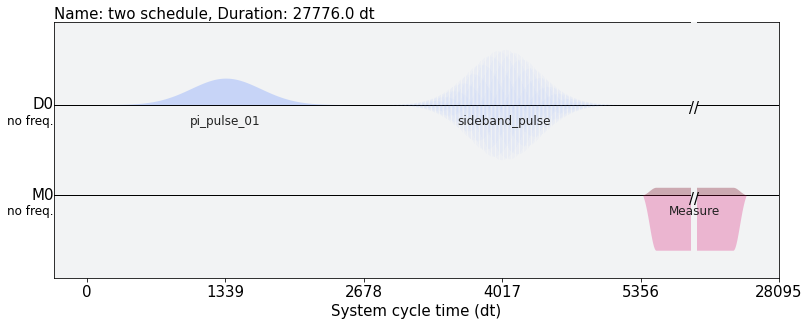

In [216]:
two_schedule2.draw()

In [217]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule2, one_schedule2, two_schedule2],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

In [218]:
IQ_012_job = backend.run(IQ_012_program)

In [219]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

60b0f57a9f32f93ee10b8874
Job Status: job has successfully run


In [180]:
#print(IQ_012_job.job_id())
#job_monitor(IQ_012_job)
#IQ_012_job = backend.retrieve_job('60afbe825255f00317387742') #wrong pi amp all
#IQ_012_job = backend.retrieve_job('60b05185e42d84c49677adaa') #correct for x0-1
IQ_012_job = backend.retrieve_job('60b0f57a9f32f93ee10b8874')

In [181]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
#zero_data = IQ_012_job.result().get_memory(0)
#one_data = IQ_012_job.result().get_memory(1)
#two_data = IQ_012_job.result().get_memory(2)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [202]:
test_jobs2 = backend.retrieve_job('60b0c0e59f32f91bc40b8626')
test_count2 = get_job_data(test_jobs2, average=False)

In [205]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    #plt.scatter(np.real(zero_data), np.imag(zero_data), 
    #                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    #plt.scatter(np.real(one_data), np.imag(one_data), 
    #                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    #plt.scatter(np.real(two_data), np.imag(two_data), 
    #                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    
    plt.scatter(np.real(test_count2), np.imag(test_count2), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'M')
    
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

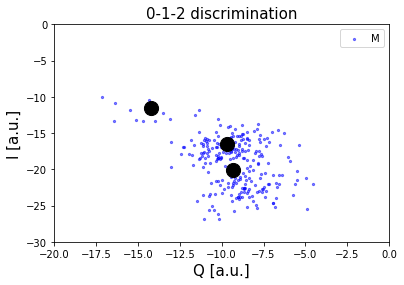

In [206]:
x_min = -20
x_max = 0
y_min = -30
y_max = 0
IQ_012_plot(x_min, x_max, y_min, y_max)

In [207]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


In [208]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

3072


In [209]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [210]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[1. 0. 0.]


In [211]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.8131510416666666


The last step is to plot the separatrix. 

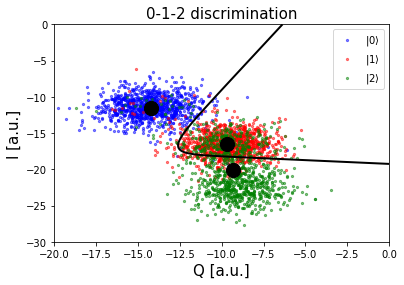

In [189]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

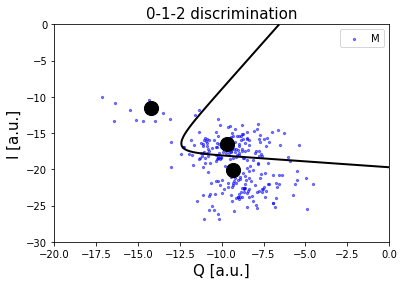

In [212]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)